In [109]:
!pip install keras_nlp

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string

import tensorflow as tf
from keras.layers import Layer
import keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense, GRU, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
from tensorflow.keras import metrics as met
from keras_nlp import metrics as nlpMetrics

from sklearn.model_selection import train_test_split

In [111]:
!nvidia-smi

Tue Dec 23 23:33:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             33W /   70W |     250MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [112]:
from google.colab import files
uploaded = files.upload()

Saving Final compiled-Sornali.xlsx to Final compiled-Sornali (2).xlsx


In [113]:
dataset = pd.read_excel('Final compiled-Sornali.xlsx').loc[:, ['Token']]
dataset[:10]

,Token
0,পাকিস্তানের
1,খাইবার
2,পাখতুনখোয়া
3,প্রদেশের
4,একটি
5,মন্দিরে
6,ভাঙচুর
7,-
8,অগ্নিসংযোগের
9,ঘটনা


In [114]:
dataset.dropna(inplace=True)
count_nan = dataset.isnull().sum()
print('Number of NaN values present: \n' + str(count_nan))

Number of NaN values present: 
Token    0
dtype: int64


In [115]:
words = []
for word in dataset['Token']:
    words.append(word)

print('Total words:', len(words))
print('Total unique words:', len(set(words)))
print('First 10 words are given as follows:\n')
words[:10]

Total words: 4699
Total unique words: 2045
First 10 words are given as follows:



['পাকিস্তানের',
 'খাইবার ',
 'পাখতুনখোয়া',
 'প্রদেশের',
 'একটি',
 'মন্দিরে',
 'ভাঙচুর',
 '-',
 'অগ্নিসংযোগের',
 'ঘটনা']

In [116]:
index = []
cnt = 0

for token in words:
    if token == '?' or token == '!' or token == '।':
        index.append(cnt)
    cnt += 1

print(index[:10])

[11, 20, 35, 45, 64, 73, 97, 117, 147, 158]


In [117]:
current = 0
previous = 0
sentences = []

for token in words:
    if current in index:
        s = slice(previous, current + 1)
        previous = current + 1
        sentences.append(words[s])

    current += 1

print('Total sequences:', len(sentences))
sentences[:5]

Total sequences: 331


[['পাকিস্তানের',
  'খাইবার ',
  'পাখতুনখোয়া',
  'প্রদেশের',
  'একটি',
  'মন্দিরে',
  'ভাঙচুর',
  '-',
  'অগ্নিসংযোগের',
  'ঘটনা',
  'ঘটে',
  '।'],
 ['এ',
  'ঘটনায়',
  'পাকিস্তানের',
  'বিরুদ্ধে',
  'তীব্র',
  'প্রতিবাদ',
  'জানিয়েছে',
  'ভারত',
  '।'],
 ['সেই',
  'সঙ্গে',
  'শুক্রবার',
  'এই',
  'ঘটনার',
  'জন্য',
  'দায়ীদের',
  'বিরুদ্ধে',
  'কঠোর',
  'ব্যবস্থা',
  'নেওয়ার',
  'দাবি',
  'করা',
  'হয়েছে',
  '।'],
 ['ভারতের',
  'দাবি',
  ',',
  'পাকিস্তান',
  'এই',
  'ঘটনার',
  'সুষ্ঠু',
  'তদন্ত',
  'করবে',
  '।'],
 ['এর',
  'আগে',
  'বুধবার',
  'কারাক',
  'জেলার',
  'তেরি',
  'গ্রামের',
  'মন্দিরটি',
  'সম্প্রসারণের',
  'কাজের',
  'প্রতিবাদ',
  'করলে',
  'সেখানকার',
  'জনতা',
  'ওই',
  'মন্দিরটি',
  'ভাঙচুর',
  'করে',
  '।']]

In [118]:
sequences = []
for sequence in sentences:
    for seqLength in range(2, len(sequence)+1):
        for i in range(seqLength, len(sequence)+1):
            sequences.append(sequence[i-seqLength:i])

print("Total sequences:", len(sequences))
sequences[:10]

Total sequences: 41398


[['পাকিস্তানের', 'খাইবার '],
 ['খাইবার ', 'পাখতুনখোয়া'],
 ['পাখতুনখোয়া', 'প্রদেশের'],
 ['প্রদেশের', 'একটি'],
 ['একটি', 'মন্দিরে'],
 ['মন্দিরে', 'ভাঙচুর'],
 ['ভাঙচুর', '-'],
 ['-', 'অগ্নিসংযোগের'],
 ['অগ্নিসংযোগের', 'ঘটনা'],
 ['ঘটনা', 'ঘটে']]

In [119]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sequences)
TokenizedSequence = tokenizer.texts_to_sequences(sequences)
TokenizedSequence = np.array(TokenizedSequence, dtype=object)
TokenizedSequence[:10]

array([list([254, 1778]), list([1778, 1605]), list([1605, 1514]),
       list([1514, 163]), list([163, 1430]), list([1430, 979]),
       list([979, 954]), list([954, 1515]), list([1515, 41]),
       list([41, 610])], dtype=object)

In [120]:
index = tokenizer.index_word

In [121]:
vocabLength = len(tokenizer.word_counts) + 1
print('Vocabulary size: {}'.format(vocabLength))

Vocabulary size: 2046


In [122]:
input = []
target = []
for i in range(len(TokenizedSequence)):
    input.append(TokenizedSequence[i][:-1])
    target.append(TokenizedSequence[i][-1])

print('First 10 tokenized sequences of input array:\n')
print(input[:10])
print('\n\nFirst 10 tokenized sequences of output array:\n')
print(target[:10])

First 10 tokenized sequences of input array:

[[254], [1778], [1605], [1514], [163], [1430], [979], [954], [1515], [41]]


First 10 tokenized sequences of output array:

[1778, 1605, 1514, 163, 1430, 979, 954, 1515, 41, 610]


In [123]:
max_sequence_len = max([len(x) for x in input])
input = np.array(pad_sequences(input, maxlen=max_sequence_len, padding='pre'))

In [124]:
class attention(Layer):
    def __init__(self, **kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self, input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self, x):
        e = tf.math.tanh(tf.matmul(x,self.W)+self.b)
        e = tf.squeeze(e, axis=-1)

        alpha = tf.nn.softmax(e)
        alpha = tf.expand_dims(alpha, axis=-1)

        context = x * alpha
        context = tf.reduce_sum(context, axis=1)
        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = super(attention, self).get_config()
        return config

In [125]:
test = 0.10
validation = 0.10
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=test, shuffle=True)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=validation, shuffle=True)

In [126]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)
x_test = np.array(x_test)
y_test = np.array(y_test)

print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of x_valid:', x_valid.shape)
print('Shape of y_valid:', y_valid.shape)
print('Shape of x_test:', x_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of x_train: (33532, 53)
Shape of y_train: (33532,)
Shape of x_valid: (3726, 53)
Shape of y_valid: (3726,)
Shape of x_test: (4140, 53)
Shape of y_test: (4140,)


In [127]:
wordSeqList = []

for seq in x_train.tolist():
    wordList = []
    for token in seq:
        if (token != 0): wordList.append(index[token])

    wordSeqList.append(wordList)

wordSeqList[:5]

[['বছরে'],
 ['শুক্রবার',
  'দুপুরে',
  'জামালপুরের',
  'ইসলামপুর',
  'উপজেলার',
  'গোয়ালেরচর',
  'ইউনিয়নের',
  'তিনটি',
  'সরকারি',
  'প্রাথমিক',
  'বিদ্যালয়ের',
  'নতুন'],
 ['হয়'],
 ['সদস্য',
  'জাহাঙ্গীর',
  'হোসেন',
  ',',
  'মুক্তিযোদ্ধা',
  'সংসদের',
  'সাবেক',
  'ডেপুটি',
  'কমান্ডার',
  'আলী',
  'হোসেন',
  'তালুকদার',
  ',',
  'শিক্ষানুরাগী'],
 ['রোগভোগ',
  'ও',
  'অনিশ্চয়তা',
  ',',
  'লকডাউনের',
  'কড়া',
  'বিধিনিষেধ',
  'আর',
  'সেই',
  'মহামারির',
  'ধ্বংসস্তূপের',
  'মধ্য',
  'থেকে',
  'আবার',
  'জীবনের',
  'জেগে',
  'ওঠার',
  'লড়াইয়ের',
  'বছর',
  'ছিল',
  '২০২০']]

In [130]:
def perplexity(y_true, y_pred):
     cross_entropy = tf.losses.sparse_categorical_crossentropy(y_true, y_pred)
     perplexity = tf.exp(tf.reduce_mean(cross_entropy))
     return perplexity

In [132]:
from gensim.models import Word2Vec, KeyedVectors
w2vModel = Word2Vec(wordSeqList, vector_size=200)

embedding_weights = np.zeros((vocabLength, 200))
word2id = tokenizer.word_index
for word, index in word2id.items():
    try:
        item = w2vModel.wv.__getitem__(word)
        embedding_weights[index, :] = item
    except KeyError:
        pass

In [133]:
model = Sequential()
model.add(Embedding(input_dim=vocabLength, output_dim=200, input_shape=(max_sequence_len,))) # Removed input_length, added input_shape
# model.add(BatchNormalization()) # Removed this BatchNormalization layer
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(BatchNormalization())
model.add(attention())
model.add(BatchNormalization())
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dense(vocabLength, activation='softmax'))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 53, 200)        │       409,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 53, 256)        │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 53, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_5 (attention)         │ (None, 256)            │           309 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2046)           │       525,822 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,341,091 (5.12 MB)

 Trainable params: 1,339,555 (5.11 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [134]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[met.SparseCategoricalAccuracy()])

In [135]:
checkpoint = ModelCheckpoint("NWP-BiLSTM.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose = 1)
earlyStop = EarlyStopping(monitor='val_loss', patience=5, verbose = 1)

logdir='logsNWP-BiLSTM'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

In [136]:
modelHistory = model.fit(x_train, y_train, batch_size=64, epochs=100, callbacks=[checkpoint, reduce, earlyStop], validation_data=(x_valid, y_valid))

Epoch 1/100
521/524 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.0776 - sparse_categorical_accuracy: 0.2921
Epoch 1: val_loss improved from inf to 15.51741, saving model to NWP-BiLSTM.h5


524/524 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 5.0629 - sparse_categorical_accuracy: 0.2939 - val_loss: 15.5174 - val_sparse_categorical_accuracy: 0.0024 - learning_rate: 0.0010
Epoch 2/100
521/524 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5897 - sparse_categorical_accuracy: 0.8778
Epoch 2: val_loss improved from 15.51741 to 1.96199, saving model to NWP-BiLSTM.h5


524/524 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.5896 - sparse_categorical_accuracy: 0.8778 - val_loss: 1.9620 - val_sparse_categorical_accuracy: 0.6151 - learning_rate: 0.0010
Epoch 3/100
521/524 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3762 - sparse_categorical_accuracy: 0.9112
Epoch 3: val_loss did not improve from 1.96199
524/524 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.3763 - sparse_categorical_accuracy: 0.9112 - val_loss: 2.8123 - val_sparse_categorical_accuracy: 0.5596 - learning_rate: 0.0010
Epoch 4/100
522/524 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3440 - sparse_categorical_accuracy: 0.9161
Epoch 4: val_loss improved from 1.96199 to 1.31208, saving model to NWP-BiLSTM.h5


524/524 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.3441 - sparse_categorical_accuracy: 0.9161 - val_loss: 1.3121 - val_sparse_categorical_accuracy: 0.7558 - learning_rate: 0.0010
Epoch 5/100
523/524 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3118 - sparse_categorical_accuracy: 0.9231
Epoch 5: val_loss improved from 1.31208 to 0.87321, saving model to NWP-BiLSTM.h5


524/524 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.3118 - sparse_categorical_accuracy: 0.9231 - val_loss: 0.8732 - val_sparse_categorical_accuracy: 0.8435 - learning_rate: 0.0010
Epoch 6/100
523/524 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2962 - sparse_categorical_accuracy: 0.9280
Epoch 6: val_loss did not improve from 0.87321
524/524 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.2963 - sparse_categorical_accuracy: 0.9280 - val_loss: 1.2915 - val_sparse_categorical_accuracy: 0.7681 - learning_rate: 0.0010
Epoch 7/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2807 - sparse_categorical_accuracy: 0.9292
Epoch 7: val_loss did not improve from 0.87321
524/524 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.2807 - sparse_categorical_accuracy: 0.9292 - val_loss: 1.2593 - val_sparse_categorical_accuracy: 0.7869 - learning_rate: 0.0010
Epoch 8/100
521/524 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2647 - sparse_categorical_accuracy: 0.9332
Epoch 8: val_loss did not improve from 0.8732

524/524 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.2147 - sparse_categorical_accuracy: 0.9402 - val_loss: 0.4560 - val_sparse_categorical_accuracy: 0.9106 - learning_rate: 2.0000e-04
Epoch 10/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.9440
Epoch 10: val_loss improved from 0.45598 to 0.45434, saving model to NWP-BiLSTM.h5


524/524 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.9440 - val_loss: 0.4543 - val_sparse_categorical_accuracy: 0.9117 - learning_rate: 2.0000e-04
Epoch 11/100
523/524 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1550 - sparse_categorical_accuracy: 0.9416
Epoch 11: val_loss did not improve from 0.45434
524/524 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.1551 - sparse_categorical_accuracy: 0.9415 - val_loss: 0.4637 - val_sparse_categorical_accuracy: 0.9128 - learning_rate: 2.0000e-04
Epoch 12/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1536 - sparse_categorical_accuracy: 0.9432
Epoch 12: val_loss did not improve from 0.45434
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.1536 - sparse_categorical_accuracy: 0.9432 - val_loss: 0.4764 - val_sparse_categorical_accuracy: 0.9122 - learning_rate: 2.0000e-04
Epoch 13/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1569 - sparse_categorical_accuracy: 0.9405
Epoch 13: val_loss did not 

In [137]:
trainLoss, trainAccuracy = model.evaluate(x_train, y_train, verbose = 1)
print('Training Loss: {:.4f}'.format(trainLoss))
print('Training Accuracy: {:.2f}%'.format(trainAccuracy * 100))
# Perplexity is not calculated by the current metrics
# print('Training Perplexity: {:.4f}'.format(trainPerplexity))

1048/1048 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1318 - sparse_categorical_accuracy: 0.9467
Training Loss: 0.1282
Training Accuracy: 94.90%


In [139]:
testLoss, testAccuracy = model.evaluate(x_test, y_test, verbose = 1)
print('Testing Loss: {:.4f}'.format(testLoss))
print('Testing Accuracy: {:.2f}%'.format(testAccuracy * 100))
# print('Testing Perplexity: {:.4f}'.format(testPerplexity)) # Perplexity is not calculated by the current metrics

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5271 - sparse_categorical_accuracy: 0.9096
Testing Loss: 0.5093
Testing Accuracy: 91.06%


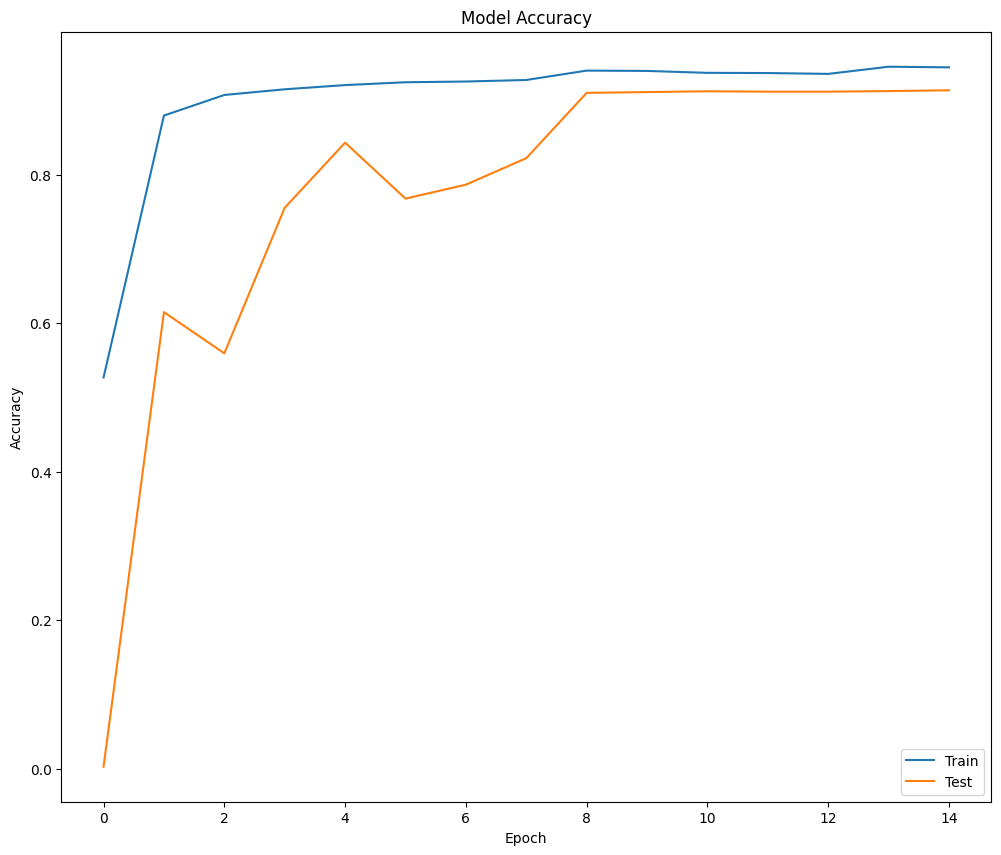

In [140]:
plt.figure(figsize=(12, 10))
plt.plot(modelHistory.history['sparse_categorical_accuracy'])
plt.plot(modelHistory.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc="lower right")
plt.savefig('acc-vs-epoch.png')
plt.show()

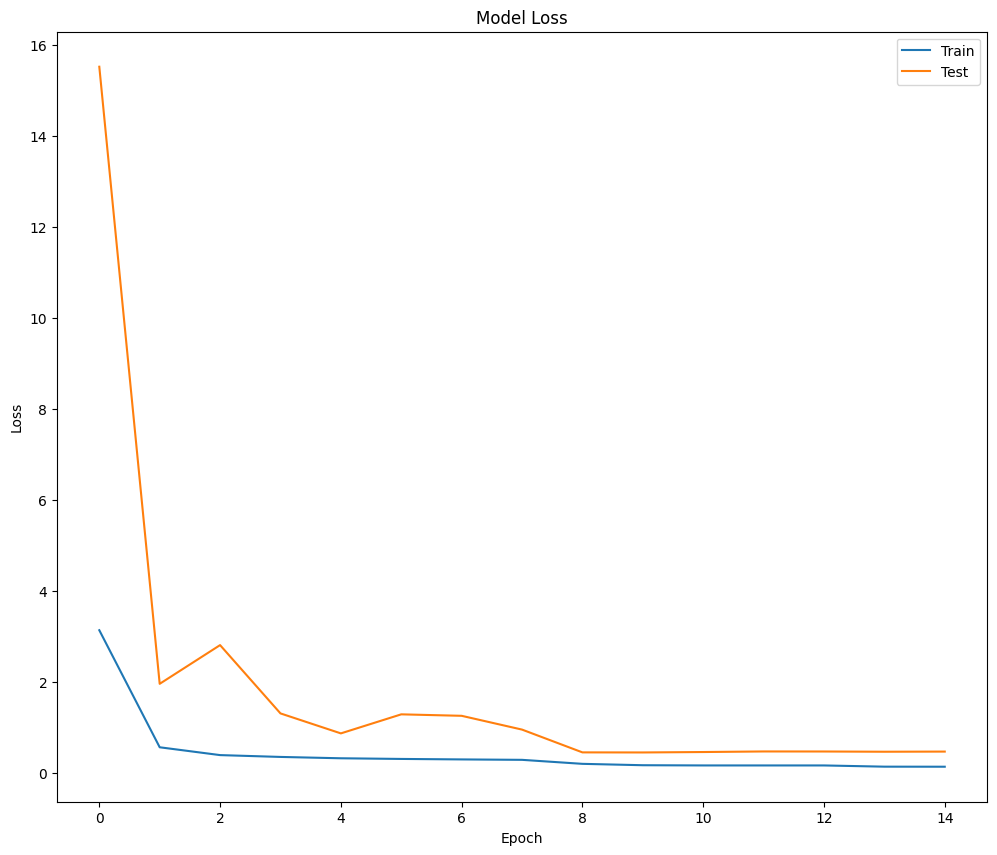

In [141]:
plt.figure(figsize=(12, 10))
plt.plot(modelHistory.history['loss'])
plt.plot(modelHistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc="upper right")
plt.savefig('loss-vs-epoch.png')
plt.show()

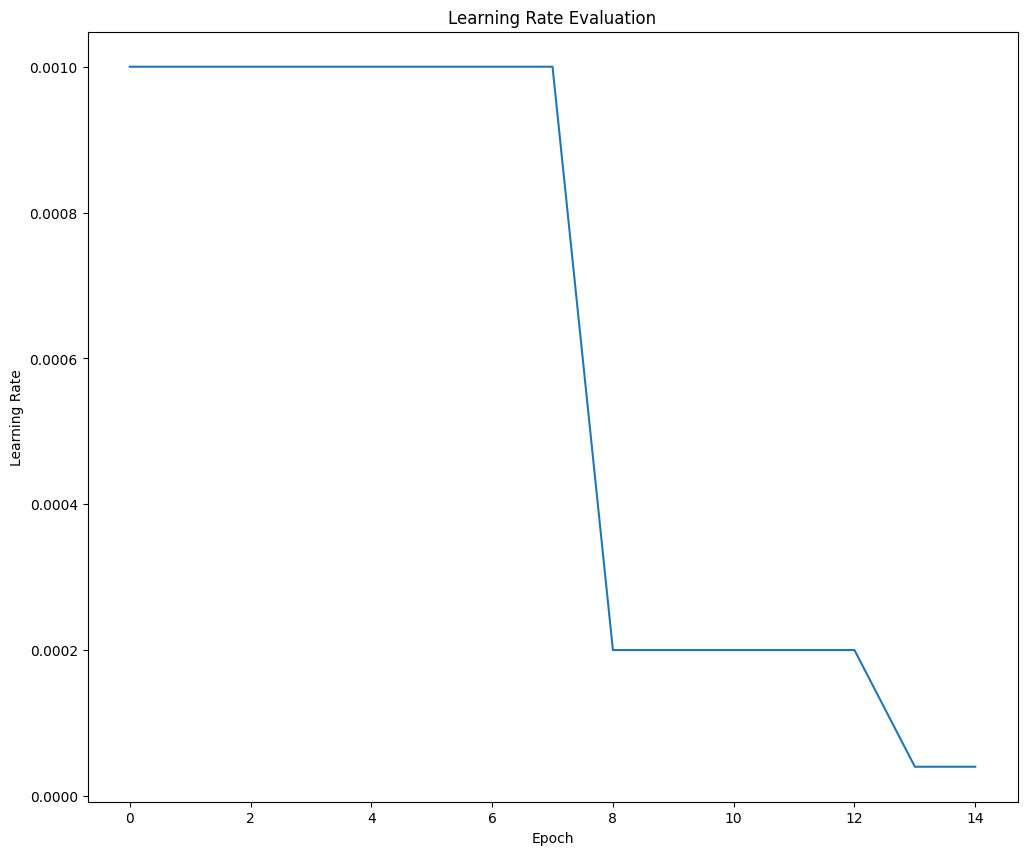

In [143]:
plt.figure(figsize=(12, 10))
plt.plot(modelHistory.history['learning_rate'])
plt.title('Learning Rate Evaluation')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.savefig('lr-vs-epoch.png')
plt.show()

In [144]:
index_to_word = tokenizer.index_word
# print(index_to_word)

In [145]:
def test_from_testset():
    i = 225 # The index of the test sample to check.
    y_predicted = model.predict(np.array([x_test[i]])) # Returns the predicted value y for the input test sample.
    y_predicted = np.argmax(y_predicted, axis=-1) # Convert probability vectors to integer labels.

    inp = ''
    for token in x_test[i]:
        if token != 0:
            inp += index_to_word[token]
            if token != x_test[i][-1]:
                inp += ' '

    print('Input sequence:', inp)
    print('Predicted next word:', index_to_word[y_predicted[0]])
    print('Actual next word:', index_to_word[y_test[i]])

    print('\nFull sequence with input and prediction')
    print('-'*40)
    print(inp + ' ' + index_to_word[y_predicted[0]])

In [146]:
test_from_testset()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Input sequence: কাজ করেছেন এবং আমাদের মধ্য থেকে জেপির যেসব
Predicted next word: নেতাকর্মী
Actual next word: নেতাকর্মী

Full sequence with input and prediction
----------------------------------------
কাজ করেছেন এবং আমাদের মধ্য থেকে জেপির যেসব নেতাকর্মী


In [147]:
# এ ধরনের গাছও প্রচুর আছে বলে দাবি করি
# for next word prediction
# def input_from_user(strval):
#     i = 0
#     while True:
#         if i != 0:
#           strval += (' ' + index_to_word[y_predicted[0]])
#           inputSen = (strval).split()
#         else: inputSen = (strval).split()
#         inp = tokenizer.texts_to_sequences(inputSen)
#         inp = [item for sublist in inp for item in sublist] # to create a flatten list
#         inp = pad_sequences([inp], maxlen=max_sequence_len, padding='pre')

#         y_predicted = model.predict(inp) # Returns the predicted value y for the input test sample.
#         y_predicted = np.argmax(y_predicted, axis=-1) # Convert probability vectors to integer labels.

#         strinp = ' '.join([str(elem) for elem in inputSen])
#         print('Input sequence:', strinp)
#         print('Predicted next word:', index_to_word[y_predicted[0]])
#         out = strinp + ' ' + index_to_word[y_predicted[0]]
#         print('\nFull sequence with input and prediction')
#         print('-'*40)
#         print(out + '\n')
#         if index_to_word[y_predicted[0]] == '।': break
#         i += 1

# for sentence completion
def input_from_user(strval):
    i = 0
    inpstr = strval
    while True:
        if i != 0:
          strval += (' ' + index_to_word[y_predicted[0]])
          inputSen = (strval).split()
        else: inputSen = (strval).split()
        inp = tokenizer.texts_to_sequences(inputSen)
        inp = [item for sublist in inp for item in sublist] # to create a flatten list
        inp = pad_sequences([inp], maxlen=max_sequence_len, padding='pre')

        y_predicted = model.predict(inp) # Returns the predicted value y for the input test sample.
        y_predicted = np.argmax(y_predicted, axis=-1) # Convert probability vectors to integer labels.

        check = index_to_word[y_predicted[0]]
        if check == '।' or check == '?' or check == '!': break
        i += 1

    strinp = ' '.join([str(elem) for elem in inputSen])
    print('Input sequence:', inpstr)
    out = strinp + index_to_word[y_predicted[0]]
    print('\nSentence completion prediction')
    print('-'*31)
    print(out + '\n')

In [148]:
input_from_user('এ ধরনের')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Input sequence: এ ধরনের

Sentence completion prediction
-------------------------------
এ ধরনের ঘটনা ও নৃশংসতার ঘটনা বারবার ঘটনা বিষয়ে পাকিস্তান হাই কমিশনকে জানিয়েছিল ভারতের পররাষ্ট্র মন্ত্রণালয়।



In [150]:
# for downloading from kaggle
import os
from IPython.display import FileLink
# os.chdir(r'/kaggle/working') # This line caused the FileNotFoundError
FileLink(r'NWP.h5')

/content/NWP.h5

In [151]:
import pickle
pickle.dump(tokenizer, open('wordTokenizerNWP.pkl', 'wb'))

files.download('wordTokenizerNWP.pkl')
files.download('NWP-BiLSTM.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [152]:
files.download('acc-vs-epoch.png')
files.download('loss-vs-epoch.png')
files.download('lr-vs-epoch.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>